[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/rishitdagli/identify-plant-diseases-tensorflow)

In [ ]:
!nvidia-smi

Sun Apr 16 08:48:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tfds-nightly tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
builder = tfds.builder('plant_village')
info = builder.info

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteT6C6YA/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

38


In [ ]:
class_names = metadata.features
print(class_names)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=38),
})


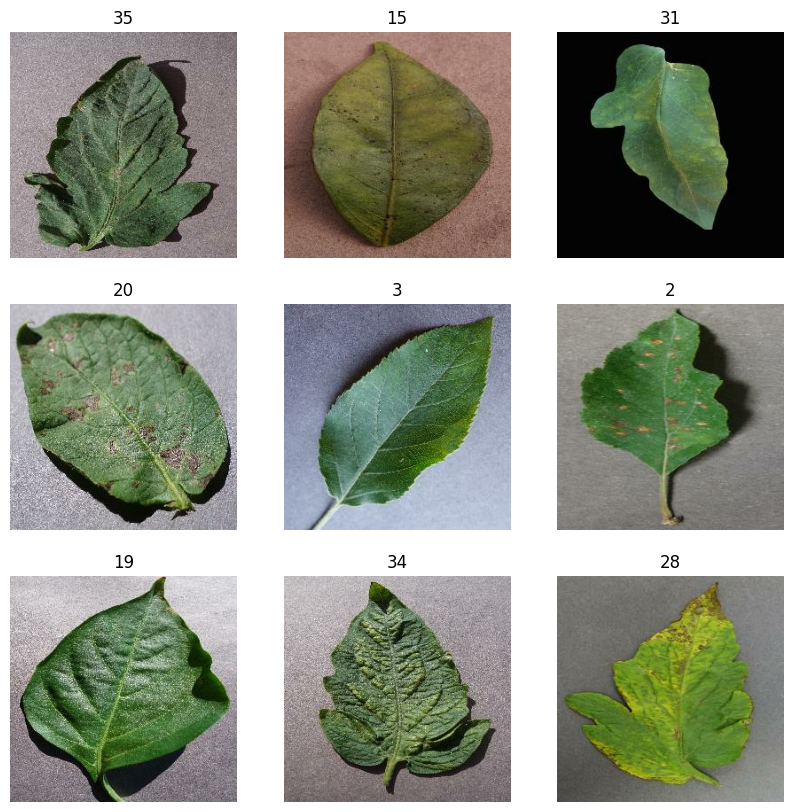

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 8
epochs = 5

In [ ]:
#size=(224,224)

#train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
#val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))
#test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
   ds = ds.cache()
   ds = ds.shuffle(buffer_size=1000)
   ds = ds.batch(batch_size)
   ds = ds.prefetch(buffer_size=AUTOTUNE)
   return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

## Training

We first get the base MobileNet model without including the top layers since we want to use it for 38 classes and us the pre-trained weights for ImageNet.

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
import keras

inputs = keras.Input(shape=input_shape, name="digits")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pool_1")(x)
x = tf.keras.layers.Dropout(0.2,name="dropout")(x)
outputs = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="PlantDoc_MobileNet")

We now create a small upstream model on top of the MobileNet using the functional API

In [ ]:
# import keras

# inputs = keras.Input(shape = input_shape)

# x = base_model(inputs, training = False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(num_classes, 
#                           activation="softmax")(x)

# model = keras.Model(inputs = inputs, 
#                     outputs = x, 
#                     name="LeafDisease_MobileNet")

In [ ]:
model.summary()

Model: "PlantDoc_MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 pool_1 (GlobalAveragePoolin  (None, 576)              0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 predictions (Dense)         (None, 27)                15579     
                                                                 
Total params: 954,699
Trainable params: 15,579
N

In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    steps_per_epoch=500,
                    validation_steps=400)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


500/500 [==============================] - 30s 34ms/step - loss: 1.5894 - accuracy: 0.6077 - val_loss: 0.6695 - val_accuracy: 0.8644
Epoch 2/5
500/500 [==============================] - 12s 24ms/step - loss: 0.6036 - accuracy: 0.8528 - val_loss: 0.4211 - val_accuracy: 0.8966
Epoch 3/5
500/500 [==============================] - 15s 31ms/step - loss: 0.4388 - accuracy: 0.8800 - val_loss: 0.3223 - val_accuracy: 0.9216
Epoch 4/5
500/500 [==============================] - 16s 31ms/step - loss: 0.3425 - accuracy: 0.9080 - val_loss: 0.2754 - val_accuracy: 0.9344
Epoch 5/5
500/500 [==============================] - 11s 23ms/step - loss: 0.2861 - accuracy: 0.9255 - val_loss: 0.2305 - val_accuracy: 0.9444


## Review the training process

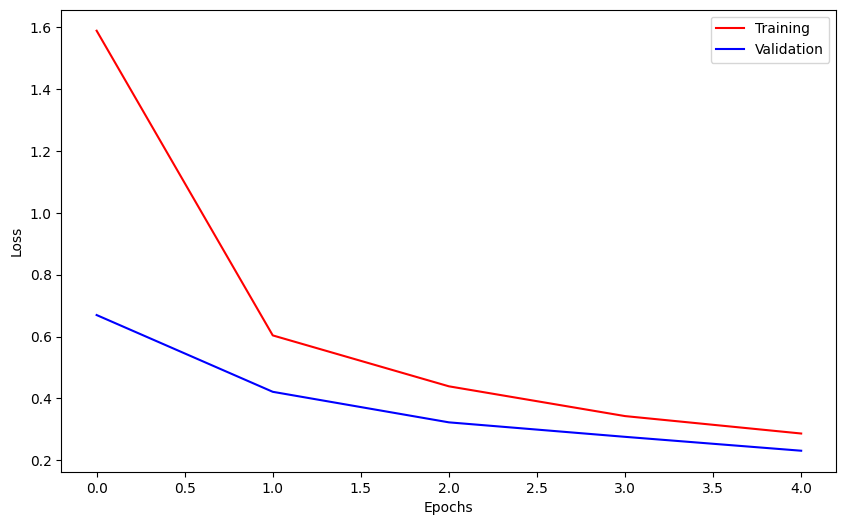

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

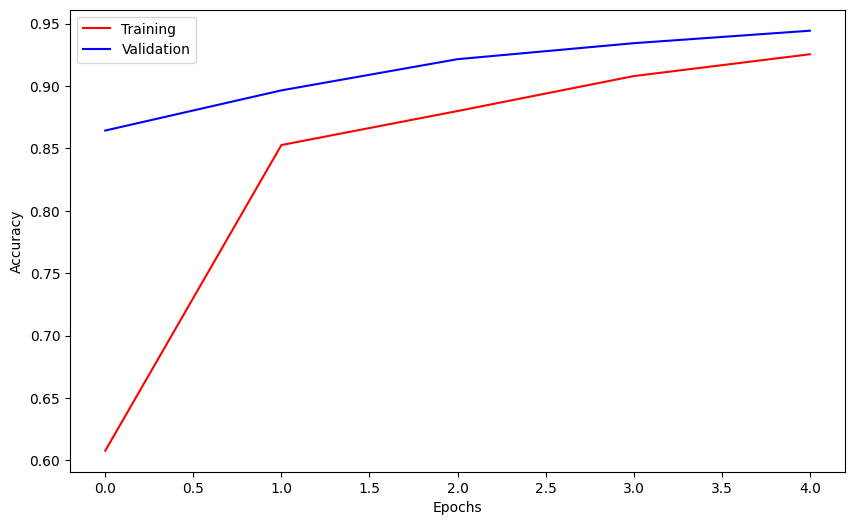

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Save the model

We finally save the model in the standard TensorFlow 2 SavedModel format.

In [ ]:
model.save_weights('/content/drive/MyDrive/Plants Recognition/НИР/Осень 2022/plantvillage_model_weights.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)